Practice using Pandas to deal with missing data

Original work at http://pandas.pydata.org/pandas-docs/stable/missing_data.html

In [78]:
import pandas as pd
import numpy as np
from scipy import interpolate
%matplotlib inline

Generate missing data by reindexing

In [6]:
df = pd.DataFrame(np.random.randn(5, 3), 
                  index=['a', 'c', 'e', 'f', 'h'], 
                  columns=['one', 'two', 'three'])
df['four'] = 'bar'
df['five'] = df['one'] > 0
df

,one,two,three,four,five
a,0.906892,-0.596566,0.998571,bar,True
c,0.363016,0.171602,-0.398902,bar,True
e,0.669215,-0.222658,0.914070,bar,True
f,-0.037141,-0.222924,-0.358535,bar,False
h,-2.022421,0.576614,-0.047509,bar,False


In [7]:
df2 = df.reindex(['a','b','c','d','e','f','g','h'])
df2

,one,two,three,four,five
a,0.906892,-0.596566,0.998571,bar,True
b,NaN,NaN,NaN,NaN,NaN
c,0.363016,0.171602,-0.398902,bar,True
d,NaN,NaN,NaN,NaN,NaN
e,0.669215,-0.222658,0.914070,bar,True
f,-0.037141,-0.222924,-0.358535,bar,False
g,NaN,NaN,NaN,NaN,NaN
h,-2.022421,0.576614,-0.047509,bar,False


Pandas provides the ```isnull()``` and ```notnull()``` functions, which are also methods of the ```Series``` and ```DataFrame``` classes, to allow the user to find and visualize missing and non-missing values.

In [8]:
df2['one']

a    0.906892
b         NaN
c    0.363016
d         NaN
e    0.669215
f   -0.037141
g         NaN
h   -2.022421
Name: one, dtype: float64

In [9]:
pd.isnull(df2['one'])

a    False
b     True
c    False
d     True
e    False
f    False
g     True
h    False
Name: one, dtype: bool

In [11]:
df2['four'].notnull()

a     True
b    False
c     True
d    False
e     True
f     True
g    False
h     True
Name: four, dtype: bool

In [12]:
df2.isnull()

,one,two,three,four,five
a,False,False,False,False,False
b,True,True,True,True,True
c,False,False,False,False,False
d,True,True,True,True,True
e,False,False,False,False,False
f,False,False,False,False,False
g,True,True,True,True,True
h,False,False,False,False,False


WARNING: in Python and NumPy, ```NaN```s don't compare equal, but ```None```s do.  

In [13]:
None == None

True

In [14]:
np.nan == np.nan

False

Pandas treats ```None``` like ```np.nan```, so using the ```==``` test for empty values in a ```Series``` or ```DataFrame``` object is useless

In [15]:
df2['one'] == np.nan

a    False
b    False
c    False
d    False
e    False
f    False
g    False
h    False
Name: one, dtype: bool

In [16]:
df2['one'] == None

a    False
b    False
c    False
d    False
e    False
f    False
g    False
h    False
Name: one, dtype: bool

For ```DateTime```s, ```NaT``` represents missing values

In [17]:
df2 = df.copy()
df2['timestamp'] = pd.Timestamp('20120101')
df2

,one,two,three,four,five,timestamp
a,0.906892,-0.596566,0.998571,bar,True,2012-01-01
c,0.363016,0.171602,-0.398902,bar,True,2012-01-01
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,-2.022421,0.576614,-0.047509,bar,False,2012-01-01


In [19]:
df2.ix[['a','c','h'],['one','timestamp']] = np.nan
df2

,one,two,three,four,five,timestamp
a,NaN,-0.596566,0.998571,bar,True,NaT
c,NaN,0.171602,-0.398902,bar,True,NaT
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,NaN,0.576614,-0.047509,bar,False,NaT


In [20]:
df2.get_dtype_counts()

bool              1
datetime64[ns]    1
float64           3
object            1
dtype: int64

You can insert missing data by assigning it to a given location or column.  The representation of that missing data will vary based on the dtype of the associated container.  For example, if I insert missing data into a ```Series```, it will be represented as ```NaN```, no matter the form in which I inserted it.

In [21]:
s = pd.Series([1,2,3])
s.loc[0] = None
s

0    NaN
1    2.0
2    3.0
dtype: float64

Similarly, no matter how I insert missing data into a datetime container, it will be represented as ```NaT```.

For object containers, Pandas will use the value given

In [22]:
s = pd.Series(['a','b','c'])
s.loc[0] = None
s.loc[1] = np.nan
s

0    None
1     NaN
2       c
dtype: object

Missing values propagate naturally through arithmetic operations between Pandas objects

In [24]:
a = df2[['one','two']]
a

,one,two
a,NaN,-0.596566
c,NaN,0.171602
e,0.669215,-0.222658
f,-0.037141,-0.222924
h,NaN,0.576614


In [26]:
b = df2[['one','two','three']]
b

,one,two,three
a,NaN,-0.596566,0.998571
c,NaN,0.171602,-0.398902
e,0.669215,-0.222658,0.914070
f,-0.037141,-0.222924,-0.358535
h,NaN,0.576614,-0.047509


In [27]:
a+b

,one,three,two
a,NaN,NaN,-1.193132
c,NaN,NaN,0.343203
e,1.338431,NaN,-0.445316
f,-0.074282,NaN,-0.445849
h,NaN,NaN,1.153228


Pandas' descriptive statistics methods are written to account for missing data.  For example, when summing data, NA (missing) values will be treated as zero; if the summed values are all NA, the final result will be NA as well; methods like ```cumsum``` and ```cumprod``` don't include NA values in the cumulative calculation, but they are displayed in the resulting arrays in the same places where they appear in the original arrays.

In [31]:
b['one'].sum()

0.63207447947303919

In [32]:
b.mean(1)

a    0.201003
c   -0.113650
e    0.453542
f   -0.206200
h    0.264552
dtype: float64

In [33]:
b.cumsum()

,one,two,three
a,NaN,-0.596566,0.998571
c,NaN,-0.424964,0.599669
e,0.669215,-0.647622,1.513738
f,0.632074,-0.870547,1.155204
h,NaN,-0.293933,1.107695


NA values in GroupBy are automatically excluded

In [34]:
b.groupby('one').mean()

,two,three
one,,
-0.037141,-0.222924,-0.358535
0.669215,-0.222658,0.914070


The ```fillna()``` function can fill in missing data in several different ways: 

Replacement with a scalar:

In [35]:
df2.fillna(0)

,one,two,three,four,five,timestamp
a,0.000000,-0.596566,0.998571,bar,True,1970-01-01
c,0.000000,0.171602,-0.398902,bar,True,1970-01-01
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,0.000000,0.576614,-0.047509,bar,False,1970-01-01


Replacement with a string (in this case, nothing will happen, because no data is missing): 

In [36]:
df2['four'].fillna('missing')

a    bar
c    bar
e    bar
f    bar
h    bar
Name: four, dtype: object

Filling gaps forward or backward: 

In [37]:
df2.fillna(method='pad')

,one,two,three,four,five,timestamp
a,NaN,-0.596566,0.998571,bar,True,NaT
c,NaN,0.171602,-0.398902,bar,True,NaT
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,-0.037141,0.576614,-0.047509,bar,False,2012-01-01


In [38]:
df2

,one,two,three,four,five,timestamp
a,NaN,-0.596566,0.998571,bar,True,NaT
c,NaN,0.171602,-0.398902,bar,True,NaT
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,NaN,0.576614,-0.047509,bar,False,NaT


```'ffill''``` is equivalent to ```'pad'```

In [39]:
df2.fillna(method='ffill')

,one,two,three,four,five,timestamp
a,NaN,-0.596566,0.998571,bar,True,NaT
c,NaN,0.171602,-0.398902,bar,True,NaT
e,0.669215,-0.222658,0.914070,bar,True,2012-01-01
f,-0.037141,-0.222924,-0.358535,bar,False,2012-01-01
h,-0.037141,0.576614,-0.047509,bar,False,2012-01-01


We can limit the number of cells that will be filled forward or backward

In [40]:
df = b
df['one'] = None
df.ix[['e','f'],['two','three']] = None
df

/Users/svenchilton/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/svenchilton/anaconda/envs/python3/lib/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,one,two,three
a,None,-0.596566,0.998571
c,None,0.171602,-0.398902
e,None,NaN,NaN
f,None,NaN,NaN
h,None,0.576614,-0.047509


In [41]:
df.fillna(method='pad', limit=1)

,one,two,three
a,None,-0.596566,0.998571
c,None,0.171602,-0.398902
e,None,0.171602,-0.398902
f,None,NaN,NaN
h,None,0.576614,-0.047509


In [42]:
dff = pd.DataFrame(np.random.randn(10,3), columns=list('ABC'))
dff.iloc[3:5,0] = np.nan
dff.iloc[4:6,1] = np.nan
dff.iloc[5:8,2] = np.nan
dff

,A,B,C
0,-0.741725,-0.392811,-0.140539
1,-0.835386,1.591470,-0.821380
2,-0.312160,0.604608,-0.344797
3,NaN,0.414342,-0.488648
4,NaN,NaN,-1.785056
5,-0.340045,NaN,NaN
6,-0.703462,0.597628,NaN
7,-0.435093,1.283862,NaN
8,0.811309,-2.170937,1.844341
9,1.032425,0.010478,-0.403015


In [43]:
dff.fillna(dff.mean())

,A,B,C
0,-0.741725,-0.392811,-0.140539
1,-0.835386,1.591470,-0.821380
2,-0.312160,0.604608,-0.344797
3,-0.190517,0.414342,-0.488648
4,-0.190517,0.242330,-1.785056
5,-0.340045,0.242330,-0.305585
6,-0.703462,0.597628,-0.305585
7,-0.435093,1.283862,-0.305585
8,0.811309,-2.170937,1.844341
9,1.032425,0.010478,-0.403015


In [46]:
dff.fillna(dff.mean()['B':'C'])

,A,B,C
0,-0.741725,-0.392811,-0.140539
1,-0.835386,1.591470,-0.821380
2,-0.312160,0.604608,-0.344797
3,NaN,0.414342,-0.488648
4,NaN,0.242330,-1.785056
5,-0.340045,0.242330,-0.305585
6,-0.703462,0.597628,-0.305585
7,-0.435093,1.283862,-0.305585
8,0.811309,-2.170937,1.844341
9,1.032425,0.010478,-0.403015


In [47]:
dff.where(pd.notnull(dff), dff.mean(), axis='columns')

,A,B,C
0,-0.741725,-0.392811,-0.140539
1,-0.835386,1.591470,-0.821380
2,-0.312160,0.604608,-0.344797
3,-0.190517,0.414342,-0.488648
4,-0.190517,0.242330,-1.785056
5,-0.340045,0.242330,-0.305585
6,-0.703462,0.597628,-0.305585
7,-0.435093,1.283862,-0.305585
8,0.811309,-2.170937,1.844341
9,1.032425,0.010478,-0.403015


```dropna()```

In [52]:
df = df.fillna(df.mean())
df

,one,two,three
a,NaN,-0.596566,0.998571
c,NaN,0.171602,-0.398902
e,NaN,0.050550,0.184053
f,NaN,0.050550,0.184053
h,NaN,0.576614,-0.047509


In [53]:
df.dropna(axis=0)

,one,two,three


In [54]:
df.dropna(axis=1)

,two,three
a,-0.596566,0.998571
c,0.171602,-0.398902
e,0.050550,0.184053
f,0.050550,0.184053
h,0.576614,-0.047509


```interpolate()```

In [61]:
ts2 = pd.Series(data=[0.469112, None, -5.689738, None, -8.916232], 
                index=[pd.Timestamp('20000131'),
                       pd.Timestamp('20000229'),
                       pd.Timestamp('20020731'),
                       pd.Timestamp('20050131'),
                       pd.Timestamp('20080430')])
ts2

2000-01-31    0.469112
2000-02-29         NaN
2002-07-31   -5.689738
2005-01-31         NaN
2008-04-30   -8.916232
dtype: float64

In [62]:
ts2.interpolate()

2000-01-31    0.469112
2000-02-29   -2.610313
2002-07-31   -5.689738
2005-01-31   -7.302985
2008-04-30   -8.916232
dtype: float64

In [63]:
ts2.interpolate(method='time')

2000-01-31    0.469112
2000-02-29    0.273271
2002-07-31   -5.689738
2005-01-31   -7.095568
2008-04-30   -8.916232
dtype: float64

In [65]:
ser = pd.Series(data=[0.0, None, 10.0], index=[0.0, 1.0, 10.0])
ser

0.0      0.0
1.0      NaN
10.0    10.0
dtype: float64

In [66]:
ser.interpolate()

0.0      0.0
1.0      5.0
10.0    10.0
dtype: float64

In [67]:
ser.interpolate(method='values')

0.0      0.0
1.0      1.0
10.0    10.0
dtype: float64

In [68]:
df = pd.DataFrame({'A': [1, 2.1, np.nan, 4.7, 5.6, 6.8],
                   'B': [.25, np.nan, np.nan, 4, 12.2, 14.4]})
df

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [69]:
df.interpolate()

,A,B
0,1.0,0.25
1,2.1,1.50
2,3.4,2.75
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [72]:
df.interpolate(method='barycentric')

,A,B
0,1.00,0.250
1,2.10,-7.660
2,3.53,-4.515
3,4.70,4.000
4,5.60,12.200
5,6.80,14.400


In [73]:
df.interpolate(method='pchip')

,A,B
0,1.00000,0.250000
1,2.10000,0.672808
2,3.43454,1.928950
3,4.70000,4.000000
4,5.60000,12.200000
5,6.80000,14.400000


In [74]:
df.interpolate(method='akima')

ValueError: invalid method 'akima' to interpolate.

In [75]:
df.interpolate(method='spline', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-0.428598
2,3.404545,1.206900
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


In [76]:
df.interpolate(method='polynomial', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-4.161538
2,3.547059,-2.911538
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


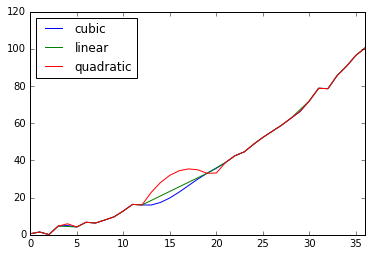

In [79]:
np.random.seed(2)
ser = pd.Series(np.arange(1, 10.1, .25)**2 + np.random.randn(37))
bad = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])
ser[bad] = np.nan
methods = ['linear', 'quadratic', 'cubic']
df = pd.DataFrame({m: ser.interpolate(method=m) for m in methods})
df.plot()

In [80]:
ser = pd.Series(np.sort(np.random.uniform(size=100)))
# interpolate at new_index
new_index = ser.index | pd.Index([49.25, 49.5, 49.75, 50.25, 50.5, 50.75])
interp_s = ser.reindex(new_index).interpolate(method='pchip')
interp_s[49:51]

49.00    0.471410
49.25    0.476841
49.50    0.481780
49.75    0.485998
50.00    0.489266
50.25    0.491814
50.50    0.493995
50.75    0.495763
51.00    0.497074
dtype: float64

Interpolation limits

In [81]:
ser = pd.Series([np.nan, np.nan, 5, np.nan, np.nan, np.nan, 13])
ser.interpolate(limit=2)

0     NaN
1     NaN
2     5.0
3     7.0
4     9.0
5     NaN
6    13.0
dtype: float64

By default, the ```limit``` argument is set so that interpolation is only carried out in the forward direction, but we can change this

In [82]:
ser.interpolate(limit=1) # limit_direction='forward'

0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5     NaN
6    13.0
dtype: float64

In [83]:
ser.interpolate(limit=1, limit_direction='backward')

0     NaN
1     5.0
2     5.0
3     NaN
4     NaN
5    11.0
6    13.0
dtype: float64

In [84]:
ser.interpolate(limit=1, limit_direction='both')

0     NaN
1     5.0
2     5.0
3     7.0
4     NaN
5    11.0
6    13.0
dtype: float64

Replacing genering values

In a ```Series```, you can replace a single value or list of values with another value

In [87]:
ser = pd.Series([0., 1., 2., 3., 4.])
ser.replace(0,5)

0    5.0
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64

You can replace a list of values with another list

In [88]:
ser.replace([0,1,2,3,4],[4,3,2,1,0])

0    4.0
1    3.0
2    2.0
3    1.0
4    0.0
dtype: float64

You can also specify a mapping dictionary

In [89]:
ser.replace({0:10, 1:100})

0     10.0
1    100.0
2      2.0
3      3.0
4      4.0
dtype: float64

For a ```DataFrame```, you can specify individual values to be replaced by column

In [90]:
df = pd.DataFrame({'a': [0, 1, 2, 3, 4], 'b': [5, 6, 7, 8, 9]})

In [91]:
df.replace({'a':0, 'b':5}, 100)

,a,b
0,100,100
1,1,6
2,2,7
3,3,8
4,4,9


Instead of replacing with specified values, you can treat all given values as missing and interpolate over them

In [93]:
ser.replace([1, 2, 3], method='pad')

0    0.0
1    0.0
2    0.0
3    0.0
4    4.0
dtype: float64

String/regex replacement:

Replace the ```'.'``` with ```NaN``` (str -> str)

In [97]:
df = pd.DataFrame({'a': list(range(4)), 'b': list('ab..'), 'c': ['a', 'b', np.nan, 'd']})
df.replace('.', np.nan)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


The command below yields an identical result to the one above, at least to my eye, but according to the documentation/tutorial website, it removes surrounding white spaces, i.e. it's a regex -> regex replacement

In [98]:
df.replace(r'\s*\.\s*', np.nan, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


Replace a few different values (list -> list)

In [99]:
df.replace(['a','.'],['b',np.nan])

,a,b,c
0,0,b,b
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


list of regex -> list of regex

In [100]:
df.replace([r'\.', r'(a)'], ['dot', '\1stuff'], regex=True)

,a,b,c
0,0,stuff,stuff
1,1,b,b
2,2,dot,NaN
3,3,dot,d


Only search in column 'b' (dict -> dict)

In [101]:
df.replace({'b': '.'}, {'b': np.nan})

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


Same as the previous example, but use a regular expression for searching instead (dict of regex -> dict)

In [102]:
df.replace({'b': r'\s*\.\s*'}, {'b': np.nan}, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


You can pass nested dictionaries of regular expressions that use regex=True

In [103]:
df.replace({'b': {'b': r''}}, regex=True)

,a,b,c
0,0,a,a
1,1,,b
2,2,.,NaN
3,3,.,d


or you can pass the nested dictionary like so

In [104]:
df.replace(regex={'b': {r'\s*\.\s*': np.nan}})

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


You can also use the group of a regular expression match when replacing (dict of regex -> dict of regex), this works for lists as well

In [105]:
df.replace({'b': r'\s*(\.)\s*'}, {'b': r'\1ty'}, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,.ty,NaN
3,3,.ty,d


You can pass a list of regular expressions, of which those that match will be replaced with a scalar (list of regex -> regex)

In [106]:
df.replace([r'\s*\.\s*', r'a|b'], np.nan, regex=True)

,a,b,c
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,d


All of the regular expression examples can also be passed with the to_replace argument as the regex argument. In this case the value argument must be passed explicitly by name or regex must be a nested dictionary. The previous example, in this case, would then be

In [107]:
df.replace(regex=[r'\s*\.\s*', r'a|b'], value=np.nan)

,a,b,c
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,d
